> **Notebook source:** Significant amount of code comes from the Keras example on [FullyConnected VAE](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py). Added changes to the model architecture so that it better corresponds to the one we saw in the slides (the original example flattened the images and used only FullyConnected/Dense layers - we instead talked about the many advantages of using Convolutional layers).

**PS: Good alternative examples of Auto Encoders:**

*   The Keras original [FullyConnected VAE](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py)
*   [ML4A regular AutoEncoder](https://github.com/zaidalyafeai/Notebooks/blob/master/AutoEncoders.ipynb)



# Generative models - Variational AutoEncoder using Convolutional layers


<p align="center">
<img src="https://raw.githubusercontent.com/previtus/cci_exploring_machine_intelligence/master/week05_generative-models/ml05_ae_illustration.png" width="520">
</p>

In [1]:
# Basic imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Choose dataset:

We will use a dataset with the shape such as this:

> *image pixels: (28, 28)*
> 
> *data: (N_number_of_samples, 28, 28, 1)*



In [2]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
#original_dim = image_size * image_size
#x_train = np.reshape(x_train, [-1, original_dim])
#x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
input_shape = x_train[0].shape
x_train = np.reshape(x_train, x_train.shape+(1,))
x_test = np.reshape(x_test, x_test.shape+(1,))

print("We loaded the MNIST dataset:")
print("input_shape:", input_shape)
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
We loaded the MNIST dataset:
input_shape: (28, 28)
x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


(28, 28, 1) stats: 0.99607843 0.0 0.12882152


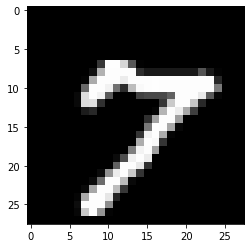

In [3]:
# Let's look at one sample:
x1 = x_test[9000]
print(x1.shape, "stats:", np.max(x1), np.min(x1), np.mean(x1))

plt.figure(figsize=(4,4))
plt.imshow(x1[:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

### Alternative dataset:

We can also use the QuickDraw [dataset](https://github.com/googlecreativelab/quickdraw-dataset) by [@Zaid Alyafeai](https://twitter.com/zaidalyafeai) which was used in the [ML4A guide](https://ml4a.github.io/guides/) for regular AutoEncoder.

In [ ]:
!git clone https://github.com/zaidalyafeai/QuickDraw10

Cloning into 'QuickDraw10'...
remote: Enumerating objects: 53, done.
remote: Total 53 (delta 0), reused 0 (delta 0), pack-reused 53
Unpacking objects: 100% (53/53), done.


In [ ]:
import numpy as np

train_data = np.load('QuickDraw10/dataset/train-ubyte.npz')
test_data  = np.load('QuickDraw10/dataset/test-ubyte.npz')

x_train, y_train = train_data['a'], test_data['b']
x_test,  y_test  = test_data['a'],  test_data['b']

In [ ]:
x_train = np.expand_dims(x_train.astype('float32') / 255., 3)
x_test =  np.expand_dims(x_test.astype('float32') / 255. , 3)
print (x_train.shape)
print (x_test.shape)

(80000, 28, 28, 1)
(20000, 28, 28, 1)


(28, 28, 1) stats: 1.0 0.0 0.8244548


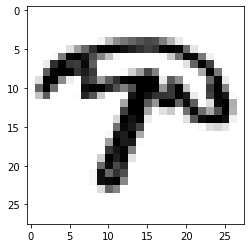

In [ ]:
# Let's look at one sample:
x1 = x_test[0] # 0 - umbrella
print(x1.shape, "stats:", np.max(x1), np.min(x1), np.mean(x1))

plt.figure(figsize=(4,4))
plt.imshow(x1[:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

## Building the model:

Image -> Encoder -> latent vector representation -> Decoder -> Reconstruction

In [4]:
# network parameters
input_shape = (28, 28, 1)
#latent_dim = 10
latent_dim = 32

# VAE model = encoder + decoder

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')

kernels = 26
x = Conv2D(kernels, (3), activation='relu', padding='same')(inputs)
#x = Conv2D(kernels, (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
#x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
intermediate_conv_shape = x.get_shape()
x = Flatten()(x)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

_,n,m,o = intermediate_conv_shape # (None, 4, 4, 6) # 96
intermediate_dim = n*m*o

#some fully connected layers in the middle?
#x = Dense(intermediate_dim, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Reshape((n,m,o))(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels), (3), activation='relu')(x)
#x = Conv2D(int(kernels), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
#x = Conv2D(int(kernels), (3), activation='relu', padding='same')(x)
###outputs = Conv2D(1, (3), activation='relu', padding='same')(x)
outputs = Conv2D(1, (3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [5]:
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 26)   260         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 26)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 13)   3055        max_pooling2d[0][0]              
____________________________________________________________________________________________

In [6]:
models = (encoder, decoder)
data = (x_test, y_test)

args_mse = False
# VAE loss = mse_loss or xent_loss + kl_loss
if args_mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs, outputs)

m = input_shape[0]*input_shape[1]
reconstruction_loss *= m # 28x28 values
reconstruction_loss = K.sum(reconstruction_loss)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_loss /= m
vae_loss /= m
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 32), (None,  10615       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    7900        encoder[0][2]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 26)   260         encoder_input[0][0]              
____________________________________________________________________________________________

In [7]:
batch_size = 128
epochs = 10

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 12s 9ms/step - loss: 39.7853 - val_loss: 23.3077
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 19.7622 - val_loss: 18.0638
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 17.0808 - val_loss: 15.5467
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 15.7745 - val_loss: 15.1743
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 14.9997 - val_loss: 14.3107
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 14.5735 - val_loss: 13.7900
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 14.2558 - val_loss: 13.4638
Epoch 8/10
469/469 [==============================] - 4s 8ms/step - loss: 13.9512 - val_loss: 13.9332
Epoch 9/10
469/469 [==============================] - 4s 8ms/step - loss: 13.6714 - val_loss: 13.4253
Epoch 10/10
469/469 [==============================] - 4s 8ms/step - loss: 13.429

Plot:


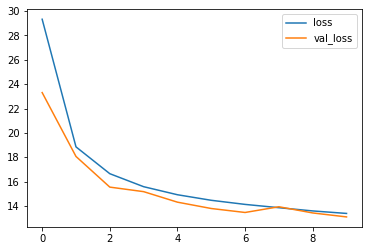

In [8]:
# How did we go?
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.legend()

print("Plot:")

In [9]:
import json

def save_model(model, name):
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights(name+".h5")

save_model(encoder,'encoder_mnist')
save_model(decoder,'decoder_mnist')
#save_model(encoder,'encoder_draw_100ep')
#save_model(decoder,'decoder_draw_100ep')

## Now let's use it!

In [ ]:
# We can carry these files (*.h5, *.json) somewhere else ...
from keras.models import load_model
from keras.models import model_from_json
import json
def my_load_model(name):
    with open(name+'.json','r') as f:
        model_json = json.load(f)

    model = model_from_json(model_json)
    model.load_weights(name+'.h5')
    return model

decoder = my_load_model('decoder_mnist')
encoder = my_load_model('encoder_mnist')
#decoder = my_load_model('decoder_draw_100ep')
#encoder = my_load_model('encoder_draw_100ep')

## Inspect one in detail:

(28, 28, 1)
1.0 0.0 0.147504


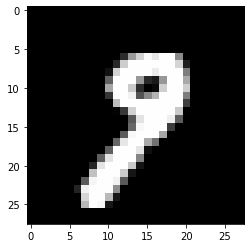

In [10]:
# Encoded image:

x1 = x_test[73]
print(x1.shape)
print(np.max(x1), np.min(x1), np.mean(x1))

img = x1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

(1, 32)
7.369352 -5.2326617 0.025146961


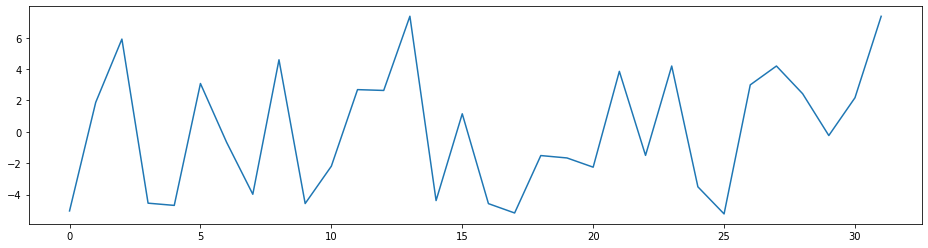

In [11]:
# Latent vector:

x1_arr = np.asarray([x1])
z, z_mean, z_log_var = encoder.predict(x1_arr)
print(z.shape)
print(np.max(z), np.min(z), np.mean(z))

plt.figure(figsize=(16,4))
plt.plot(z[0])
plt.show()

(1, 28, 28, 1)


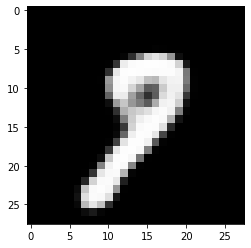

In [12]:
# Reconstructed image

y1 = decoder.predict(z)
print(y1.shape)
y1 = y1[0]

img = y1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()


## Or in triplets:

In [13]:
def plot_tripple(image, vector, reconstruction):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Image > Representation > Reconstruction')
    ax1.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    ax2.plot(vector)
    ax2.set_aspect(3.1)
    ax3.imshow(reconstruction, cmap='gray', vmin=0.0, vmax=1.0)

def plot_single(image):
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    plt.show()

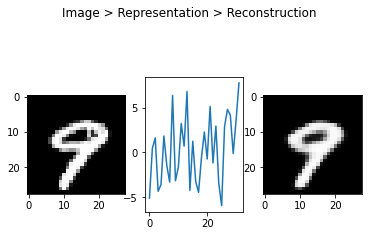

In [14]:
x1 = x_test[9] # 2 has a '1', 3 has a '0'
z, z_mean, z_log_var = encoder.predict(np.asarray([x1]))
y1 = decoder.predict(z)

plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])

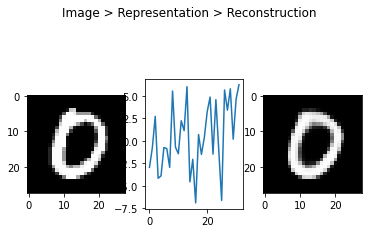

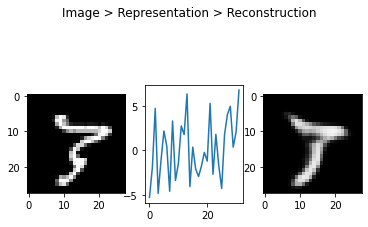

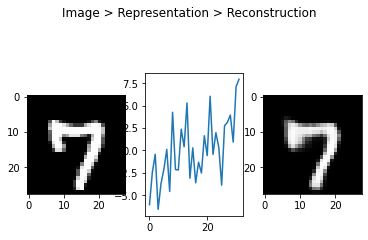

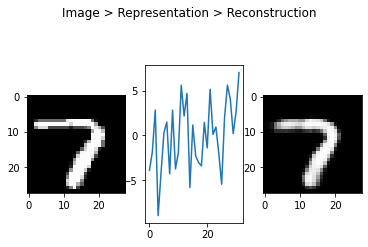

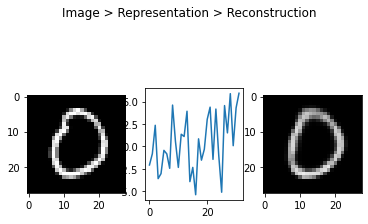

In [15]:
from random import randrange
for i in range(5):
    x1 = x_test[randrange(len(x_test))]
    z, z_mean, z_log_var = encoder.predict(np.asarray([x1]))
    y1 = decoder.predict(z)
    plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])

In [16]:
sample_a = x_test[2] # 2 has a '1'
z_sample_a_encoded, _, _ = encoder.predict(np.asarray([sample_a]))

sample_b = x_test[3] # 3 has a '0'
z_sample_b_encoded, _, _ = encoder.predict(np.asarray([sample_b]))

print("z_sample_a_encoded:", z_sample_a_encoded.shape)
print("z_sample_b_encoded:", z_sample_b_encoded.shape)

z_sample_a_encoded: (1, 32)
z_sample_b_encoded: (1, 32)


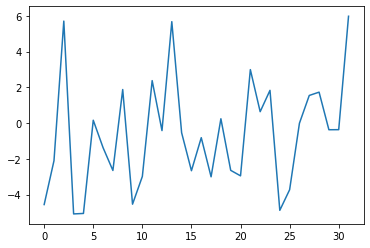

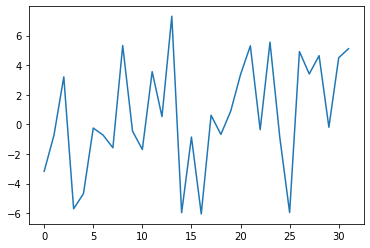

In [17]:
plt.plot(z_sample_a_encoded[0])
plt.show()
plt.plot(z_sample_b_encoded[0])
plt.show()

In [18]:
def lerp(u,v,a):
    # linear interpolation between vectors u and v
    return a*u + (1-a)*v

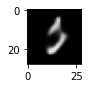

In [19]:
a = 0.5
z_mix = lerp(z_sample_a_encoded, z_sample_b_encoded, a)
image = decoder.predict(z_mix) # shape comes as (1,28,28,1)
image = image.reshape((28,28))

plot_single(image)

0.0 :


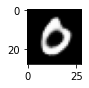

0.2 :


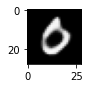

0.4 :


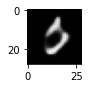

0.6 :


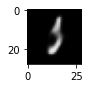

0.8 :


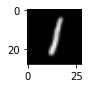

1.0 :


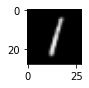

In [20]:
steps = 5
for i in range(steps + 1):
    # Goes from 0.0 to 1.0 in <steps> steps
    a_01 = float(i) / float(steps)
    z_mix = lerp(z_sample_a_encoded, z_sample_b_encoded, a_01)
    y = decoder.predict(z_mix)
    image = y.reshape((28,28))
    print(a_01,":")
    plot_single(image)

In [ ]:
# Let's add a very fancy Google Colab handler!!!

z_sample_a_encoded: (1, 32)
z_sample_b_encoded: (1, 32)
a: 0.04


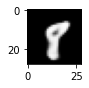

In [24]:
#@title Control over the VAE we just trained:
from IPython.utils import io

first_sample_idx = 200 #@param {type:"integer"}
second_sample_idx = 5360 #@param {type:"integer"}
interpolation = 0.04 #@param {type:"slider", min:0.0, max:1.0, step:0.01}

sample_a = x_test[first_sample_idx] # 2 has a '1'
z_sample_a_encoded, _, _ = encoder.predict(np.asarray([sample_a]))

sample_b = x_test[second_sample_idx] # 3 has a '0'
z_sample_b_encoded, _, _ = encoder.predict(np.asarray([sample_b]))

print("z_sample_a_encoded:", z_sample_a_encoded.shape)
print("z_sample_b_encoded:", z_sample_b_encoded.shape)
print("a:", interpolation)

z_mix = lerp(z_sample_a_encoded, z_sample_b_encoded, interpolation)
image = decoder.predict(z_mix) # shape comes as (1,28,28,1)
image = image.reshape((28,28))

plot_single(image)

## Random vector to image

latent =  [[ -1.5596863    3.92285544  13.80130009   2.79939444  -2.24634216
   -2.46562055  -9.07896342   4.647146    -3.99136258   0.35880485
   -0.14744039  15.48483475   0.22241879   6.89529502   1.24484997
   -1.22980922   0.70886444   1.88843078  -8.16488024   2.18270799
    9.51545819   1.47096153   3.21012105  -0.71981521  -1.6192989
   -1.56498968   5.51246332   0.88021256   0.26953136  -0.18665193
  -14.80878928  -5.34379932]]


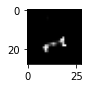

In [25]:
# Random latent
latent = np.random.randn(1, 32) * 5
print("latent = ",latent)

image = decoder.predict(latent)
image = image.reshape((28,28))

plot_single(image)

latent =  [999.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]


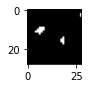

In [26]:
# We can try break it ...

latent = np.zeros(32)
latent[0] = 999.0 # oversaturated?
print("latent = ",latent)

image = decoder.predict(latent.reshape(1,32))
image = image.reshape((28,28))

plot_single(image)

## (Or) visualization as a gif:

As a bonus including a visualization from https://github.com/zaidalyafeai/Notebooks/blob/master/AutoEncoders.ipynb

In [27]:
!pip install imageio

In [28]:
import shutil 
import cv2
import imageio, glob

#linear interpolation function 
def f(x):
  return x

def interpolate(size = 10):
  if os.path.exists("images"):
    shutil.rmtree("images")
    os.makedirs('images')
  else:
    os.makedirs('images')
    
  
  
  #get 3 random batches each of size 3 
  batches = []
  for _ in range(0, 3):
    i1 = np.random.randint(0, len(x_train))
    i2 = np.random.randint(0, len(x_train))
    batches.append([x_train[i1:i1+3], x_train[i2:i2+3]])
 
  i = 0   
  for x in list(np.linspace(0, 1, size)):
    frame = None
    j = 0 
    
    #interpolate each batch and concatenate them at the end to create 3x3 images
    for (x1, x2) in batches:
    
      
      v1,_,_ = encoder.predict(x1) 
      v2,_,_ = encoder.predict(x2)
        
      #use a linear interpolater
      v = (float(x))*v1 + (1.0 - float(x))*v2
      
      #get the output and reshape it 
      y = decoder.predict(v)
      img = np.reshape(y, (3 * 28, 28))
      img = img * 255
      
      #concatenate the batches 
      if frame is None:
        frame = img
      else:
        frame = np.concatenate([frame, img], axis = 1)
      j += 1
      
    #write the current frame to the disk 
    frame = cv2.resize(frame, (256, 256))  
    cv2.imwrite(f'images/image{i}.png', frame)
    i+=1

In [29]:
!mkdir images
!ls images

In [30]:
interpolate(size = 10)

with imageio.get_writer('lsi.gif', mode='I', duration=0.35) as writer:
  filenames = glob.glob('images/image*.png')
  filenames = sorted(filenames)
  
  for i,filename in enumerate(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp lsi.gif lsi.gif.png')

0

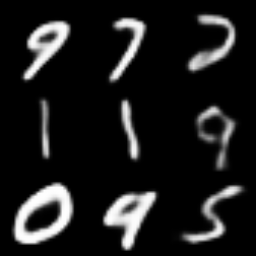

In [31]:
from IPython import display 
display.Image(filename="lsi.gif.png")

### Note: How well we can recreate those shapes also depends on the training and the model architecture (bigger or smaller as needed ...)

*(these are some results from the other dataset ...)*

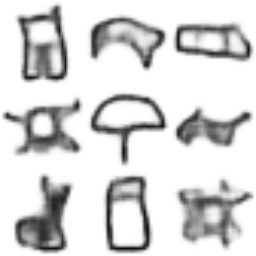

In [ ]:
# with Batch Normalization and full 100 epochs

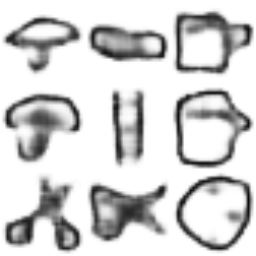

In [ ]:
# with Batch Normalization and only 20 epochs

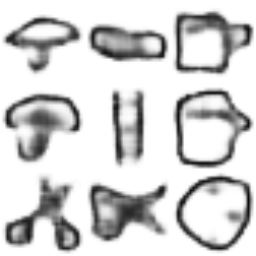

In [ ]:
# cca 60 epochs

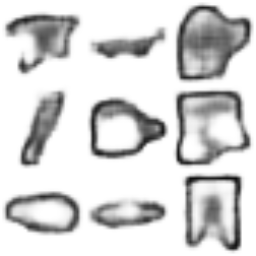

In [ ]:
# cca 20 epochs

# Want to know more?

If you are still not satisfied with the results so far ... you can check some notebooks with state-of-the-art GANs. (Their results will blow your socks off when comparing it with the current low res dataset :D) (Remember this is due to using a relatively simple model and also not that much compute ...).

Good place to start: **BigGAN notebook**: https://colab.research.google.com/drive/1rqDwIddy0eunhhV8yrznG4SNiB5XWFJJ

Additional **tricks with BigGAN**: https://github.com/zaidalyafeai/Notebooks/blob/master/BigGanEx.ipynb

*(PS: check the ML4A guides https://ml4a.github.io/guides/ for possible updates to these links)*